# Is buying every low P/FCF a profitable strategy?

In [ ]:
from fmp_data import Dataset, OfflineData
from fmp_fetch import FMPOnline
from utils.graph import per_group_return_graph  

fmp = FMPOnline()
us_stocks = OfflineData.get_us_active_stocks()
data = Dataset(us_stocks, ['fcf_per_share_ttm'], '2009-01-01', '2024-12-31', with_price=True).build()

In [36]:
data.dropna(inplace=True)
data['pfcf'] =  data['tradable_price'] / data['fcf_per_share_ttm'] 
data['one_year_return'] = data.tradable_price.shift(-365) / data.tradable_price - 1
data.dropna(inplace=True)

In [37]:
data.head()

,date,symbol,filing_date,fcf_per_share_ttm,first_effective_date,tradable_price,pfcf,one_year_return
1,2009-01-02,A,2008-12-19,1.710227,2008-12-20,10.15,5.934884,0.970443
2,2009-01-03,A,2008-12-19,1.710227,2008-12-20,10.15,5.934884,0.970443
3,2009-01-04,A,2008-12-19,1.710227,2008-12-20,10.15,5.934884,0.972414
4,2009-01-05,A,2008-12-19,1.710227,2008-12-20,10.55,6.168771,0.874408
5,2009-01-06,A,2008-12-19,1.710227,2008-12-20,11.36,6.642392,0.734595


In [85]:
spx = fmp.get_close_prices_during(['^GSPC'], '2009-01-01', '2024-12-31')
spx_full_date = pd.DataFrame({'date': pd.date_range(start='2009-01-01', end='2024-12-31')})
spx = pd.merge(spx_full_date, spx, on='date', how='left')
spx = spx.ffill()
spx['one_year_return'] = spx.close_price.shift(-365) / spx.close_price - 1
spx.dropna(inplace=True)

2025-07-14 10:32:46 - fmp_online.py:108 - INFO - Fetching close prices for 1 symbols from 2009-01-01 to 2024-12-31
100%|██████████| 1/1 [00:00<00:00, 1182.16it/s]


In [86]:
spx.head()

,date,symbol,close_price,one_year_return
1,2009-01-02,^GSPC,931.80,0.196716
2,2009-01-03,^GSPC,931.80,0.196716
3,2009-01-04,^GSPC,931.80,0.215915
4,2009-01-05,^GSPC,927.45,0.225425
5,2009-01-06,^GSPC,934.70,0.216583


# Experiments To Run

- Random dates that has > 1 year gap, buy all stocks and check 1 year returns
- Separate SPX return into categories and see how p/fcf multiple relates to 1 year return on each category
- Backetest by iterating each day, add a stock when p/fcf is low enough and hold for 1 year. Don't add duplicate stocks if they are already in the portfolio

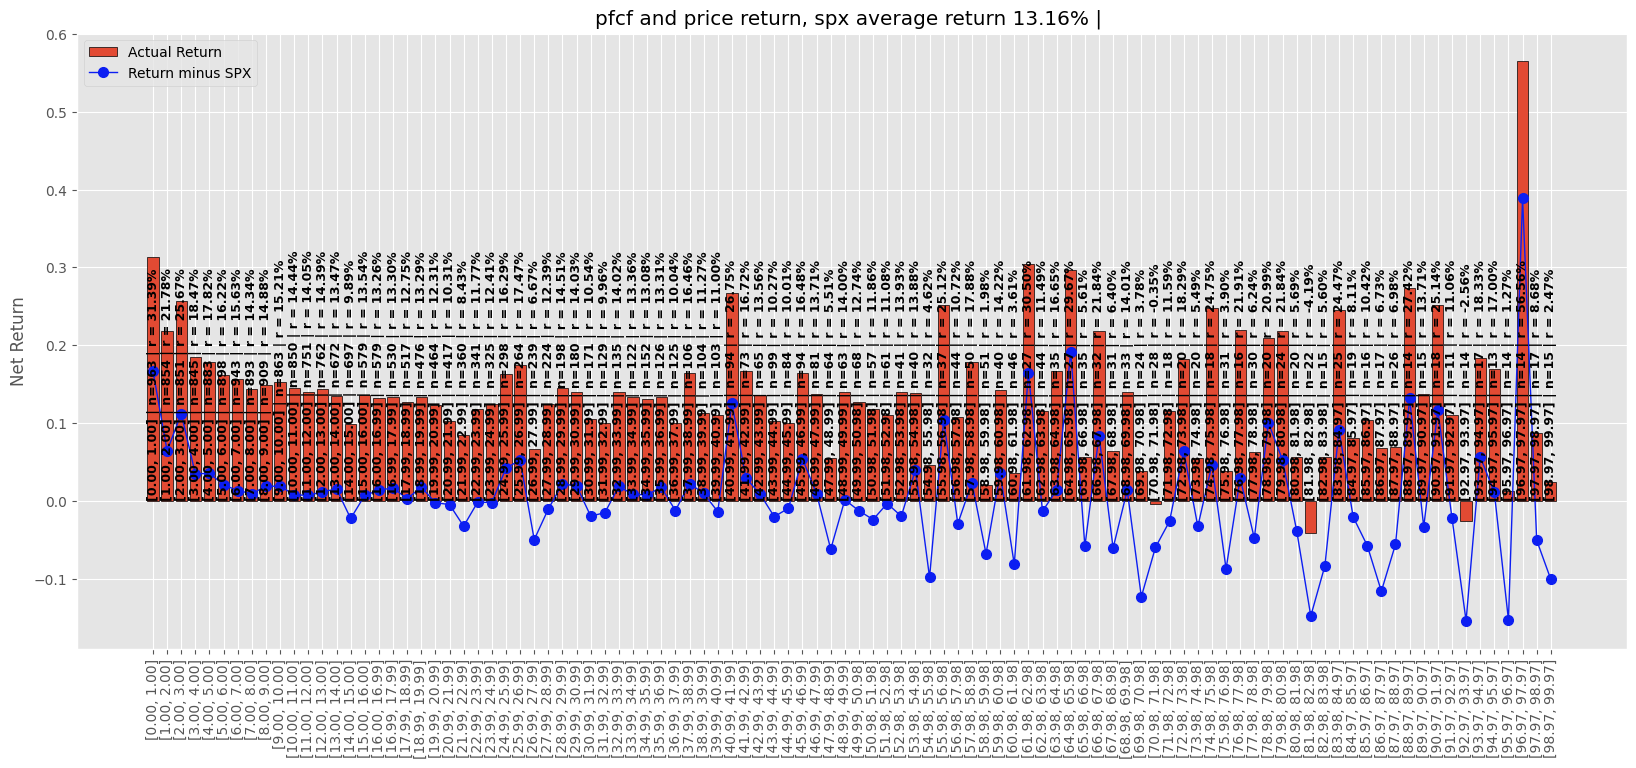

In [117]:
# Random dates
import random
date_range = pd.date_range(start='2009-01-02', end='2009-12-31', freq='D')
samples = []
for _ in range(1):
    start_date = random.choice(date_range)
    sampled_dates = pd.date_range(start=start_date, end=data.date.max(), freq='365D')
    t = data[data['date'].isin(sampled_dates)].copy()
    t = t.merge(spx[['date', 'one_year_return']], on='date', how='left', suffixes=('', '_spx'))
    t.rename(columns={'one_year_return': 'return'}, inplace=True)
    t.rename(columns={'one_year_return_spx': 'spx_return'}, inplace=True)
    t['win_spx'] = t['return'] - t['spx_return'] 
    samples.append(t)

sample = pd.concat(samples)

per_group_return_graph(sample[sample['pfcf'] > 0], 'pfcf', 0, 100, 100)

## Experiment 1 Take Away: Ultrl low P/FCF wins SPX consistently

Each time we execute the above cell, we sample a date between '2009-01-02' and '2009-12-31'. Then from that start date, each year, we buy and hold all tradable US stocks until 2024-12-31. We then group the 1-year return into P/FCF buckets. The graph shows the bucket's 1-year return and how much it wins/loses to SPX at the same period.

It seems that low P/FCF consistently beat SPX by ~10%.


In [ ]:
spx_ranges = [
    (-100, -0.1),
    (-0.1, 0),
    (0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 100),
]

for low, high in spx_ranges:
    dates = spx[spx.one_year_return.between(low, high, inclusive='left')].date
    t = data[data['date'].isin(dates) & (data.pfcf.between(0, 1, inclusive='right'))].copy()
    t = t.merge(spx[['date', 'one_year_return']], on='date', how='left', suffixes=('', '_spx'))
    t.rename(columns={'one_year_return': 'return'}, inplace=True)
    t.rename(columns={'one_year_return_spx': 'spx_return'}, inplace=True)
    t['win_spx'] = t['return'] - t['spx_return'] 
    print(f"""
    {len(dates)} days has SPX yearly returns between [{low}, {high}),
    the avearge SPX yearly return is {spx[spx.date.isin(dates)].one_year_return.mean()*100:.2f}%,
    selected portfolio yearly return is {t['return'].mean()*100:.2f}%,
    win/loss over SPX: {t['win_spx'].mean()*100:.2f}%""")




    219 days has SPX yearly returns between [-100, -0.1),
    the avearge SPX yearly return is -14.49%,
    selected portfolio yearly return is -12.96%,
    win/loss over SPX: 1.53%

    571 days has SPX yearly returns between [-0.1, 0),
    the avearge SPX yearly return is -4.03%,
    selected portfolio yearly return is -4.07%,
    win/loss over SPX: 0.52%

    1228 days has SPX yearly returns between [0, 0.1),
    the avearge SPX yearly return is 5.07%,
    selected portfolio yearly return is 5.43%,
    win/loss over SPX: 0.28%

    2060 days has SPX yearly returns between [0.1, 0.2),
    the avearge SPX yearly return is 14.86%,
    selected portfolio yearly return is 18.01%,
    win/loss over SPX: 3.06%

    938 days has SPX yearly returns between [0.2, 0.3),
    the avearge SPX yearly return is 24.09%,
    selected portfolio yearly return is 29.60%,
    win/loss over SPX: 5.20%

    316 days has SPX yearly returns between [0.3, 0.4),
    the avearge SPX yearly return is 33.82%,
  

# Experiment 2 Take away: It's Beta, but only sort of

We categorize SPX by its yearly returns into buckets and found that the [0, 1] range P/FCF portfolio beats SPX in every SPX buckets. However, while our portfolio wins everywhere, the margin is close until SPX return is over 10%. It really shines when SPX return is over 40%, in which case our portfolio has average return of over 200%! This strategy seems to be amplifiying SPX's performance while being barely advantageous when the market suffers (our portfolio suffer slightly less).

But why such a naive stragegy can be winning? Are we fooled by randomness? More tests are needed before we can be confident.

